In [1]:
from itertools import count
from IPython.display import display, Markdown, Code  
from sympy import *
init_printing()

sim_param = symbols("lambda eta_a eta_b alpha", real=True)
lambda_, eta_a, eta_b, alpha = sim_param
N, M = symbols("N M", integer=True)
sim_param += (N,M)

x1, x2 = IndexedBase("x1", shape=(M,)), IndexedBase("x2", shape=(M,))
x = IndexedBase("x", shape=(M,))
y = IndexedBase("y", shape=(N,))
i, j = symbols("i", integer=True), symbols("j", integer=True)
d = symbols("d", real=True)

relative_subs = {
    x1[0]:"x1_0",
    x1[1]:"x1_1",
    x1[2]:"x1_2",
    x1[3]:"x1_3",
    x1[j-2]:"x1_bb",
    x1[j-1]:"x1_b",
    x1[j]:"x1_j",
    x1[j+1]:"x1_n",
    x1[j+2]:"x1_nn",
    x1[M-4]:"x1_M_4",
    x1[M-3]:"x1_M_3",
    x1[M-2]:"x1_M_2",
    x1[M-1]:"x1_M_1",
    
    x2[0]:"x2_0",
    x2[1]:"x2_1",
    x2[2]:"x2_2",
    x2[3]:"x2_3",
    x2[j-2]:"x2_bb",
    x2[j-1]:"x2_b",
    x2[j]:"x2_j",
    x2[j+1]:"x2_n",
    x2[j+2]:"x2_nn",
    x2[M-4]:"x2_M_4",
    x2[M-3]:"x2_M_3",
    x2[M-2]:"x2_M_2",
    x2[M-1]:"x2_M_1",
    
    y[0]:"y_0",
    y[1]:"y_1",
    y[j-1]:"y_b",
    y[j]:"y_j",
    y[j+1]:"y_n",
    y[N-2]:"y_N_2",
    y[N-1]:"y_N_1"
}
relative_subs = {original:symbols(relative_subs[original], real=True) for original in relative_subs}

In [2]:
def break_head(expr):
    assert isinstance(expr, Sum)
    func, (index, start, stop) = expr.args
    return func.subs(index, start), Sum(func, (index, start+1, stop))

def break_tail(expr):
    assert isinstance(expr, Sum)
    func, (index, start, stop) = expr.args
    return Sum(func, (index, start, stop-1)), func.subs(index, stop)

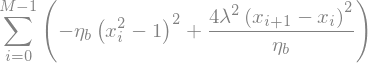

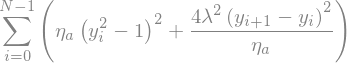

In [3]:
S = Sum(4*lambda_**2 / eta_b * (x[i+1] - x[i])**2 - eta_b* (x[i]**2 -1)**2, (i, 0, M-1))
SE = Sum(4*lambda_**2 / eta_a * (y[i+1] - y[i])**2 + eta_a* (y[i]**2 -1)**2, (i, 0, N-1))
display(S, SE)

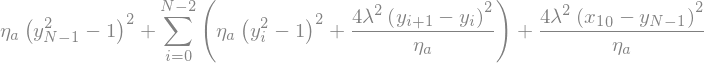

In [4]:
SE = Add(*break_tail(SE)).subs(y[N], x1[0]) # connecting the last term
display(SE)

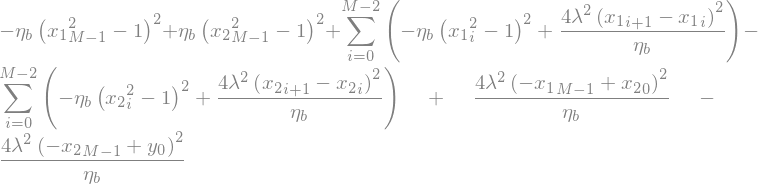

In [5]:
#creating the arg of the cosine. The connecting terms are breaked off and the path are connected
cos_arg = (Add(*break_tail(S.subs(x,x1))) - Add(*break_tail(S.subs(x,x2)))).subs(x1[M], x2[0]).subs(x2[M], y[0]) 
display(cos_arg)

In [6]:
darg_x1j = diff(cos_arg, x1[j]).doit() #deriving in respect of the first path
darg_x2j = diff(cos_arg, x2[j]).doit() #deriving in respect of the second path
darg_y0  = diff(cos_arg, y[0]).doit()
#display(darg_x1j, darg_x2j)

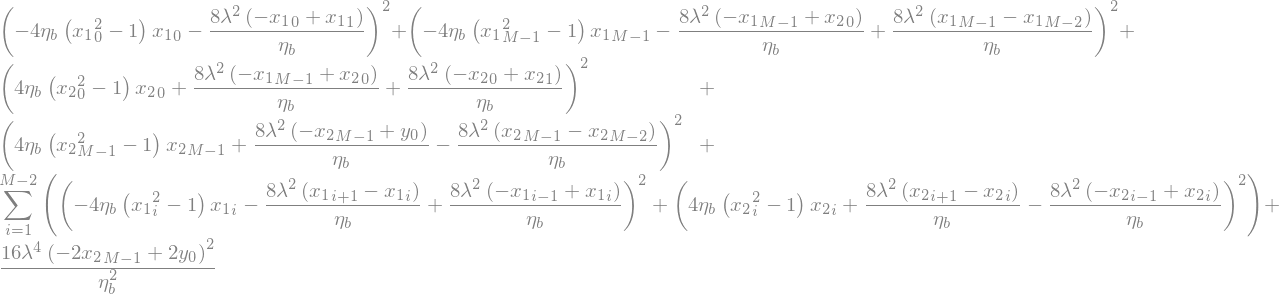

In [7]:
#creating the derivative squared
dS_sqr = piecewise_fold(darg_x1j**2 + darg_x2j**2) # the complete iesimalderivative squared, piecewised
dS_sqr = dS_sqr.subs(M-2>=j-1, M-1>=j)
dS_sqr = dS_sqr.subs((j>=0)&(j-1>=0)&(j<=M-2)&(j<=M-1), (j>=1)&(j<=M-2)) # And between disequality. this SHOULD be automatic

dS_sqr = Sum(dS_sqr, (j,0,M-1)) # summing all terms
#display(dS_sqr)
# there are special cases both for j= M-1 and j = 0
#separing the specialized ones
head, dS_sqr = break_head(dS_sqr)
dS_sqr, tail = break_tail(dS_sqr)
limit_cases = head + tail + darg_y0**2

limit_cases = limit_cases.subs((M-2>=0), True) # aka M>=2
limit_cases = limit_cases.subs(KroneckerDelta(0,M-1), 0) #Erasing delta in the limits
# simplifing the piecewise summation center. 
dS_sqr = Sum(dS_sqr.args[0].subs(j>=1, True).subs(j<=M-2, True), dS_sqr.args[1])
#erasing deltas in the summation
dS_sqr = Sum(dS_sqr.args[0].subs(KroneckerDelta(j,M-1), 0).subs(KroneckerDelta(j,0), 0), dS_sqr.args[1])
#changing index to i
dS_sqr = Sum(dS_sqr.args[0].subs(j,i), (i, ) + dS_sqr.args[1][1:])

dS_sqr += limit_cases

display(dS_sqr)

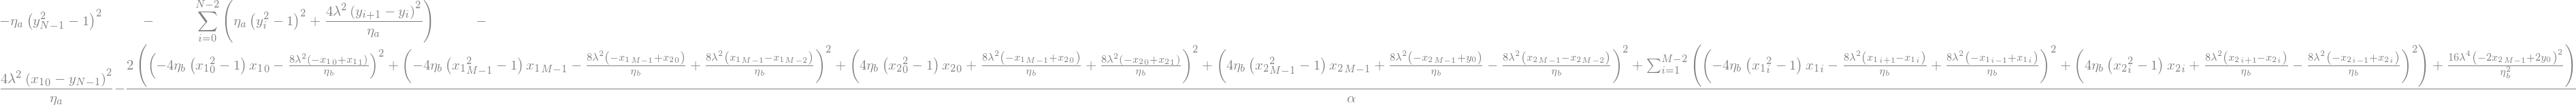

In [8]:
#time to write the monstruosity that is this exponent!
misure_exp = - SE - (2/alpha) * dS_sqr
misure_exp

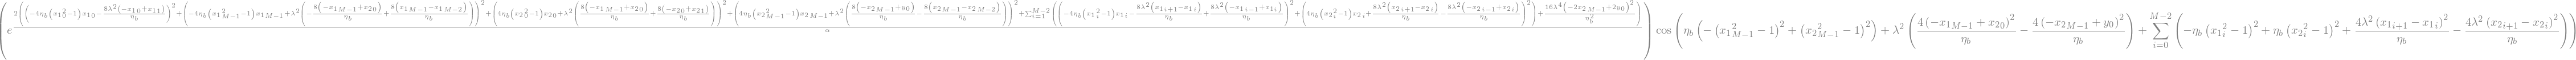

In [9]:
def join_summs(expr):
    if len(expr.args)==0:
        return expr
    if expr.func == Add:
        sums = []
        normal_terms = 0
        for arg in expr.args:
            if arg.func == Sum:
                sums.append(arg)
            elif arg.func == Mul:
                sub_sums = [summ for summ in arg.args if summ.func == Sum] # trova le somme nelle moltiplicazioni
                if len(sub_sums) != 1:
                    normal_terms += join_summs(arg) # o è normale, o non so che fare delle doppie somme
                else:
                    sub_sum = sub_sums[0]
                    rest = join_summs(
                        Mul(*(summ for summ in arg.args if summ.func != Sum)) * sub_sum.args[0] # porto il prodotto all'interno
                    )
                    sums.append(Sum(rest, sub_sum.args[1]))
            else:
                normal_terms += join_summs(arg) # tutto regolare
        for index in set(summ.args[1] for summ in sums): #senza ripetizioni
            normal_terms += Sum(
                Add(*(summ.args[0] for summ in sums if summ.args[1] == index)) # sommo tutte le somme interessanti
                , index)
        return normal_terms # e do la versione unita
    return expr.func(*(join_summs(arg) for arg in expr.args))
        

observable = join_summs(cos(cos_arg.collect(sim_param))* exp((2/alpha) * dS_sqr.collect(sim_param)))
observable

# Creating use cases

In [10]:
def indexed_substitute(expr, base, index, delta):
    """execute base[index] \to base[index] + delta"""
    if len(expr.args) == 0:
        return expr  # abbiamo raggiunto una foglia
    if expr.func == Indexed and expr.args[0] == base: # ne abbiamo trovato uno
        #eseguo la sostituzione
        return Indexed(base, indexed_substitute(expr.args[1], base, index, delta)) + delta*KroneckerDelta(expr.args[1], index)
    #else
    return expr.func(*(indexed_substitute(arg, base, index, delta) for arg in expr.args)) #recurse furter

def find_indexed(expr):
    """find all the indexed in an expression, with the indices"""
    resp = {}
    if len(expr.args) == 0:
        return resp # siamo alle foglie
    if expr.func == Indexed: #se se stesso è un indice
        resp[expr.args[0]] = set([expr.args[1] ,]) # aggiungiamo noi stessi
    for key, value in (key_value for arg in expr.args for key_value in find_indexed(arg).items()): #aggiungiamo tutti i figli
        if key in resp:
            resp[key] = resp[key].union(value) # li aggiungiamo, niente doppioni
        else:
            resp[key] = value  # ne abbiamo di nuovi
    return resp

def get_coeff(expr, simbols, erase_duplicated=True):
    """prende un'espressione polinomiale in simbols e la scompone
        Se erased_duplicated è False allora la scomplosizione è in monomi"""
    terms = [(1, expr.expand())]
    for simb in simbols:  # per ogni simbolo
        new_terms = []
        for monom, term in terms:
            # Divido in monomi in rispetto a questo simbolo
            new_terms += [
                (monom * simb**new_exp[0], coeff) 
                for new_exp, coeff in term.as_poly(simb).all_terms()
                if coeff != 0 #all terms ritorna anche i termini con coefficiente 0
            ]
        terms = new_terms # e si ripete
    # nor we check for dublicated coeff
    if erase_duplicated:
        unduped_terms = []
        for simb, term in terms:
            found = False
            for i, (simb2, term2) in enumerate(unduped_terms):  # controlliamo se è unico
                if term == term2:  # bingo!
                    unduped_terms[i]=(simb + simb2, term) # ora vi è anche questo con quel coefficente
                    found = True
                    continue
                if term == - term2:  # meglio sottrarre che moltiplicare...
                    unduped_terms[i]=(simb - simb2, term) # lo si aggiunge, ma negato
                    found = True
                    continue
            if not found:
                unduped_terms.append((simb, term))#ne abbiamo uno nuovo
        terms = unduped_terms
    return terms

class PrecalculateContext:
    """A set of values to precalculate"""
    def __init__(self, prefix="p"):
        self.values = {}
        self.symbols = IndexedBase(prefix, shape = (100,),real=True)
        self._index_gen = count()
    def add(self, term):
        for symb in self.values:
            if (self.values[symb] - term).expand() == 0: # sono uguali!
                return symb # lo abbiamo già
        new_symb = self.symbols[next(self._index_gen)] # creo un nuovo simbolo
        self.values[new_symb] = term # registro che devo calcolare pure questo
        return new_symb

class ReturnExpression:
    """A expression to save in the c file"""
    def __init__(self, name, expr, local_vars, context=None):
        self.name = name
        self.expr = expr
        self.local_vars = local_vars
        if context is None:
            self.context = self._extract_context()
        else:
            self.context = context
        self.cache = None
        self.cached_values = None 
        self.red_expr = None
        
            
    def _extract_context(self):
        "trova tutte le celle a cui l'espressione si riferisce"
        return set(self.expr.free_symbols).difference(self.local_vars).difference(sim_param) 
        # toglie le variabili locali e quelle globali
        
    def _fill_cached(self, c):
        "factor out the dependence from the context"
        self.expr = self.expr.expand() # expanding. From there expr is considered a polynomial
        self.cached_values = {}
        self.red_expr = 0
        for monom, coeff in get_coeff(self.expr, self.local_vars): # espando in termini delle variabili locali
            cache_symb = next(c)
            self.cached_values[cache_symb] = coeff # registro il coefficiente da precalcolare
            self.red_expr += cache_symb*monom # creo l'espressione ridotta
    
    def fill_precalc(self, precalculated):
        "factor out the dependence from the sym params"
        self._fill_cached(numbered_symbols("tmp")) # using temporary names, so we will swap them out
        for cache_symb, cache_term in list(self.cached_values.items()): #per ogni simbolo che ho messo in cache
            prec_terms = get_coeff(cache_term, self.context) # splitting the dependence of the cache from the context
            if len(prec_terms) == 1 and prec_terms[0][0] == 1: # è indipendente, quindi era già da precalcolare
                self.cached_values.pop(cache_symb) #bye bye
                new_symb = precalculated.add(cache_term) #aggiungiamo il termine da precalcolare
                self.red_expr = self.red_expr.subs(cache_symb, new_symb) # e lo modifichiamo nell'equazione ridotta
                continue # no need to exam the term furter
            # abbiamo da aggiungere termini
            self.cached_values[cache_symb] = Add(*
                                                 [
                                                     precalculated.add(term)*monom  #creo il termine e lo aggiungo sia alla definizione che ai precalcolati
                                                     for monom,term in prec_terms
                                                 ]
                                                )
        # now we need to create the true names for the cache
        self.cache = IndexedBase("c", shape=(len(self.cached_values),), real=True)
        for i, (tmp_cache_symb, cache_term) in enumerate(list(self.cached_values.items())):
            self.cached_values.pop(tmp_cache_symb) # erasing old definition
            self.cached_values[self.cache[i]] = cache_term # registering new symbol
            self.red_expr = self.red_expr.subs(tmp_cache_symb, self.cache[i]) # changing in the expression

# $ x1_{j} \to x1_{j} + d $

In [11]:
diff_x1_misure = indexed_substitute(misure_exp, x1, j, d) - misure_exp # the difference by sending x[j]
#writing extese form
diff_x1_misure = diff_x1_misure.expand().doit() # expmanding in monomials and executing summations
#display(diff_misure)

x1_expressions = {} #here we will collect all the expressions

In [12]:
#x1_j  (generic case)
specialized_misure = diff_x1_misure.subs(KroneckerDelta(0,j), 0).subs(KroneckerDelta(1,j), 0) # erasing limit deltas, j>=2
specialized_misure = specialized_misure.subs(KroneckerDelta(j,M-1), 0).subs(KroneckerDelta(j,M-2), 0) #erasing limit deltas, j<=M-3
specialized_misure = specialized_misure.subs(j>=1, True).subs(j+1>=1, True).subs(j-1>=1, True) # j>=2
specialized_misure = specialized_misure.subs(j<=M-2, True).subs(M-2>=j+1, True).subs(M-2>=j-1, True) # j<=M-3

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
x1_expressions[j] = ReturnExpression("diff_x1_j", specialized_misure, set((relative_subs[x1[j]],d)))
display(x1_expressions[j].context)
#display(x1_expressions[j].expr)

To erase all deltas and piecewise we excluded $j\in (0,1,M-2,M-1)$. So we explicit those cases

In [13]:
# x1_0
specialized_misure = diff_x1_misure.subs(j,0).subs(KroneckerDelta(0,M-1), 0).subs(KroneckerDelta(0,M-2), 0) # M>=3
specialized_misure = specialized_misure.subs(M-2>=1, True) # M>=3

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
x1_expressions[0] = ReturnExpression("diff_x1_0", specialized_misure, set((relative_subs[x1[0]],d)))
display(x1_expressions[0].context)
#display(x1_expressions[0].expr)

In [14]:
#x1_1
specialized_misure = diff_x1_misure.subs(j,1).subs(KroneckerDelta(1,M-1), 0).subs(KroneckerDelta(1,M-2), 0) # M>=4
specialized_misure = specialized_misure.subs(M-2>=1, True).subs(M-2>=2, True) # M>=4

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
x1_expressions[1] = ReturnExpression("diff_x1_1", specialized_misure, set((relative_subs[x1[1]],d)))
display(x1_expressions[1].context)
#display(x1_expressions[1].expr)

In [15]:
#x1_M-2
specialized_misure = diff_x1_misure.subs(j,M-2).subs(KroneckerDelta(0,M-2), 0).subs(KroneckerDelta(1,M-2), 0) # M>=4
specialized_misure = specialized_misure.subs(M-2>=1, True).subs(M-3>=1, True) # M>=4

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
x1_expressions[M-2] = ReturnExpression("diff_x1_M_2", specialized_misure, set((relative_subs[x1[M-2]],d)))
display(x1_expressions[M-2].context)
#display(x1_expressions[M-2].expr)

In [16]:
#x1_M-1
specialized_misure = diff_x1_misure.subs(j,M-1).subs(KroneckerDelta(0,M-1), 0).subs(KroneckerDelta(1,M-1), 0) # M>=3
specialized_misure = specialized_misure.subs(M-2>=1, True) # M>=3

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
x1_expressions[M-1] = ReturnExpression("diff_x1_M_1", specialized_misure, set((relative_subs[x1[M-1]],d)))
display(x1_expressions[M-1].context)
#display(x1_expressions[M-1].expr)

# $ x2_{j} \to x2_{j} + d $

In [17]:
diff_x2_misure = indexed_substitute(misure_exp, x2, j, d) - misure_exp # the difference by sending x[j]
#writing extese form
diff_x2_misure = diff_x2_misure.expand().doit() # expmanding in monomials and executing summations
#display(diff_misure)

x2_expressions = {} #here we will collect all the expressions

In [18]:
#x2_j  (generic case)
specialized_misure = diff_x2_misure.subs(KroneckerDelta(0,j), 0).subs(KroneckerDelta(1,j), 0) # erasing limit deltas, j>=2
specialized_misure = specialized_misure.subs(KroneckerDelta(j,M-1), 0).subs(KroneckerDelta(j,M-2), 0) #erasing limit deltas, j<=M-3
specialized_misure = specialized_misure.subs(j>=1, True).subs(j+1>=1, True).subs(j-1>=1, True) # j>=2
specialized_misure = specialized_misure.subs(j<=M-2, True).subs(M-2>=j+1, True).subs(M-2>=j-1, True) # j<=M-3

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
x2_expressions[j] = ReturnExpression("diff_x2_j", specialized_misure, set((relative_subs[x2[j]],d)))
display(x2_expressions[j].context)
#display(x2_expressions[j].expr)

Again we excluded $j\in (0,1,M-2,M-1)$

In [19]:
# x2_0
specialized_misure = diff_x2_misure.subs(j,0).subs(KroneckerDelta(0,M-1), 0).subs(KroneckerDelta(0,M-2), 0) # M>=3
specialized_misure = specialized_misure.subs(M-2>=1, True) # M>=3

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
x2_expressions[0] = ReturnExpression("diff_x2_0", specialized_misure, set((relative_subs[x2[0]],d)))
display(x2_expressions[0].context)
#display(x2_expressions[0].expr)

In [20]:
#x2_1
specialized_misure = diff_x2_misure.subs(j,1).subs(KroneckerDelta(1,M-1), 0).subs(KroneckerDelta(1,M-2), 0) # M>=4
specialized_misure = specialized_misure.subs(M-2>=1, True).subs(M-2>=2, True) # M>=4

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
x2_expressions[1] = ReturnExpression("diff_x2_1", specialized_misure, set((relative_subs[x2[1]],d)))
display(x2_expressions[1].context)
#display(x2_expressions[1].expr)

In [21]:
#x2_M-2
specialized_misure = diff_x2_misure.subs(j,M-2).subs(KroneckerDelta(0,M-2), 0).subs(KroneckerDelta(1,M-2), 0) # M>=4
specialized_misure = specialized_misure.subs(M-2>=1, True).subs(M-3>=1, True) # M>=4

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
x2_expressions[M-2] = ReturnExpression("diff_x2_M_2", specialized_misure, set((relative_subs[x2[M-2]],d)))
display(x2_expressions[M-2].context)
#display(x2_expressions[M-2].expr)

In [22]:
#x2_M-1
specialized_misure = diff_x2_misure.subs(j,M-1).subs(KroneckerDelta(0,M-1), 0).subs(KroneckerDelta(1,M-1), 0) # M>=3
specialized_misure = specialized_misure.subs(M-2>=1, True) # M>=3

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
x2_expressions[M-1] = ReturnExpression("diff_x2_M_1", specialized_misure, set((relative_subs[x2[M-1]],d)))
display(x2_expressions[M-1].context)
#display(x2_expressions[M-1].expr)

# $ y_{j} \to y_{j} + d $

In [23]:
diff_y_misure = indexed_substitute(misure_exp, y, j, d) - misure_exp # the difference by sending x[j]
#writing extese form
diff_y_misure = diff_y_misure.expand().doit() # expmanding in monomials and executing summations
#display(diff_misure)

y_expressions = {} #here we will collect all the expressions

In [24]:
#y_j  (generic case)
specialized_misure = diff_y_misure.subs(KroneckerDelta(0,j), 0) # erasing limit deltas, j>=1
specialized_misure = specialized_misure.subs(KroneckerDelta(j,N-1), 0) #erasing limit deltas, j<=N-2
specialized_misure = specialized_misure.subs(j>=0, True).subs(j-1>=0, True) # j>=1
specialized_misure = specialized_misure.subs(j<=N-2, True).subs(N-2>=j-1, True) # j<=N-2

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
y_expressions[j] = ReturnExpression("diff_y_j", specialized_misure, set((relative_subs[y[j]],d)))
display(y_expressions[j].context)
#display(y_expressions[j].expr)

This time $j\in (0,N-1)$ was excluded. So we only need two special cases

In [25]:
#y_0
specialized_misure = diff_y_misure.subs(j,0).subs(KroneckerDelta(0,N-1), 0) #N>=2
specialized_misure = specialized_misure.subs(N-2>=0, True) # N>=2

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
y_expressions[0] = ReturnExpression("diff_y_0", specialized_misure, set((relative_subs[y[0]],d)))
display(y_expressions[0].context)
#display(y_expressions[0].expr)

In [26]:
#y_N_1
specialized_misure = diff_y_misure.subs(j,N-1).subs(KroneckerDelta(0,N-1), 0) #N>=2
specialized_misure = specialized_misure.subs(N-2>=0, True) # N>=2

specialized_misure = specialized_misure.subs(relative_subs) # erasing indexes
y_expressions[N-1] = ReturnExpression("diff_y_N_1", specialized_misure, set((relative_subs[y[N-1]],d)))
display(y_expressions[N-1].context)
#display(y_expressions[N-1].expr)

# Creating the cache and precalculated values

In [27]:
precalculated = PrecalculateContext()
all_expressions = list(y_expressions.values()) + list(x1_expressions.values()) + list(x2_expressions.values())
for expr in all_expressions:
    expr.fill_precalc(precalculated)

In [28]:
if False: #printing math is long
    for expr in all_expressions:
        display(Markdown(f"# {expr.name}"))
        display(expr.red_expr)
        display(expr.cached_values)
    display(Markdown("# Precalculated"))
    display(precalculated.values)

In [29]:
#test
for expr in all_expressions:
    rec_expr = expr.red_expr.subs(expr.cached_values).subs(precalculated.values) # riottengo l'originale
    assert (rec_expr - expr.expr).expand() == 0  # controllo di non aver fatto casini

# Code Generation

In [45]:
from sympy.codegen.rewriting import create_expand_pow_optimization
from sympy.simplify.cse_main import cse
from sympy.codegen import ast, cnodes

optimizations_to_apply = [create_expand_pow_optimization(7)]
def optimize(term):
    for opt in optimizations_to_apply:
        term = opt(term)
    return term

def get_func(name, definitions, context, input_array=None):
    single = isinstance(definitions, Basic)
    if single: #abbiamo una sola cosa da calcolare :)
        exprs= definitions # una sola!
    else:
        exprs = [Eq(symb, expr) for symb,expr in definitions.items()] # le espressioni da calcolare
    subs, red_expr = cse(exprs, symbols = numbered_symbols("t"))
    # generate variables, optimize expressions
    temp_vars = [(ast.Variable(symb, type=ast.real), optimize(term)) for symb, term in subs]
    params = sorted([ast.Variable(symb, type=ast.real) for symb in context], key=lambda x:x.symbol.name) + \
        ([ast.Pointer(arr.name, type=ast.real) for arr in input_array] if input_array is not None else [] )
    if not single:
        out_arrays = set()
        out_vars_values = []
        for element, expr in [expr.args for expr in red_expr]: #aprendo ogni equivalenza
            if isinstance(element, Indexed):  # è un array
                out_arrays.add(element.args[0].name) #aggiungiamo l'array trovato
                out_vars_values.append(
                    (ast.Pointer(element.args[0].name, type=ast.real)[int(element.args[1])], 
                     optimize(expr))
                )
                continue # abbiamo finito
        params += [ast.Pointer(arr, type = ast.real) for arr in out_arrays] #devi ricevere anche lo spazio per l'output
    else:
        red_expr = optimize(red_expr[0]) #tocca anche a te
    #start writing the body
    body=[ast.Comment("Automatic generated code")]
    #declaring temp var
    body.append(ast.Comment("Declaring temp vars"))
    body += [ast.Declaration(var) for var, _ in temp_vars]
    #intermediate calculations
    body.append(ast.Comment("Common expressions"))
    body += [ast.Assignment(var, term) for var, term in temp_vars]
    #filling the output
    body.append(ast.Comment("Calculating output"))
    if not single:
        body += [ast.Assignment(var, term) for var, term in out_vars_values]
    else:
        body.append(ast.Return(red_expr)) # vi è solo quella da dare indietro
    #creating function...
    return ast.FunctionDefinition("void" if not single else ast.real, name, params, body)

In [46]:
# creating the code
functions = [get_func("precalculate", precalculated.values, sim_param)]
for expr in all_expressions:
    functions.append(get_func(f"cache_{expr.name}", expr.cached_values, expr.context, [precalculated.symbols]))
    functions.append(get_func(expr.name, expr.red_expr, expr.local_vars, [precalculated.symbols, expr.cache]))

In [47]:
#creating the code for the observable
def extract_sums(expr, symbols=numbered_symbols("S")):
    if len(expr.args) == 0:
        return (), expr #siamo a una foglia
    
    sums, args = zip(*(extract_sums(arg, symbols) for arg in expr.args)) # estrai da tutti gli argomenti
    if expr.func == Sum: #bingo!
        new_symb = next(symbols)
        return sum(sums, ()) + ((new_symb, expr.func(*args)), ), new_symb
    return sum(sums, ()), expr.func(*args)

#calculating how to calculate the observable
#extracting sums
sums, red_obs = extract_sums(observable)
#extracting global vars
temp_symbs = numbered_symbols("t") # ne abbiamo uno unico per evitare doppioni
indices = set(summ.args[1][0] for _, summ in sums)
global_subs, red_exprs = cse(
    [summ.args[0] for _,summ in sums] + [red_obs], symbols=temp_symbs,
    ignore= list(indices) #+ 
    #[base[index+offset] for base in [x1, x2, y] for index in indices for offset in range(-2,3)] #those must stay in the cycle
)
sums = [(symb, summ.args[1], red_expr) for (symb, summ), red_expr in zip(sums, red_exprs[:-1])]
red_obs = red_exprs[-1]
# extracting single subs
sums = [(symb, index, cse(expr, symbols=temp_symbs)) for symb, index, expr in sums]
final_subs, red_obs = cse(red_obs, symbols=temp_symbs)
#creating variables, optimizing
sums = [
    (ast.Variable(symb, type=ast.real), 
     (ast.Variable(index[0], type=ast.intc), index[1], index[2]) ,
     (tuple((ast.Variable(sub_symb, type=ast.real), optimize(sub_expr)) for sub_symb, sub_expr in subs), optimize(expr[0]))) 
    for symb, index, (subs, expr) in sums]
indices = [ast.Variable(index, type=ast.intc) for index in indices]
global_subs = [(ast.Variable(symb, type=ast.real), optimize(term)) for symb, term in global_subs]
final_subs = [(ast.Variable(symb, type=ast.real), optimize(term)) for symb, term in final_subs]
red_obs = optimize(red_obs[0])
# create the body
body = [ast.Comment("Automatic generated code")]
# creating sum variables, index variables, temp vars
body.append(ast.Comment("Declaring temp vars"))
body += [ast.Declaration(var) for var, _ , _ in sums] #variabili della sommatoria
body += [ast.Declaration(index) for index in indices] # variabili indice
body += [ast.Declaration(var) for var, _ in global_subs] # sostituzioni globali
body += [ast.Declaration(var) for _, _ ,(subs, _) in sums for var, _ in subs] # estraggo ogni varibile temporanea
body += [ast.Declaration(var) for var, _ in final_subs] # sostituzioni finali
# global substitution
body.append(ast.Comment("Global common expressions"))
body += [ast.Assignment(var, term) for var, term in global_subs]
# making sums
for var,(index, start, stop), (local_subs, expr) in sums:
    body.append(ast.Comment(f"Summing {var.symbol.name}"))
    body.append(ast.Assignment(var, 0))
    body.append(ast.For(
        index, Range(start, stop+1), #+1 cause different way of indexing
        [ast.Assignment(sub_var, sub_expr) for sub_var, sub_expr in local_subs] + #creating local variables
        [ast.aug_assign(var, "+", expr)]
    ))
body.append(ast.Comment("Returning output"))
body += [ast.Assignment(var, term) for var, term in final_subs]
body.append(ast.Return(red_obs))

functions.append(ast.FunctionDefinition(ast.real, "observable", 
                             [
                                 ast.Pointer(x1.name, type=ast.real),
                                 ast.Pointer(x2.name, type=ast.real),
                                 ast.Pointer(y.name, type=ast.real),
                             ] + [ast.Variable(symb, type=ast.real if not symb.is_integer else ast.intc) for symb in sim_param],
                            body))

In [48]:
sep = "\n\n"
h_code = f"""#ifndef DIFFS_H
#define DIFFS_H

#define PRECALC_LEN {len(precalculated.values)}
#define CACHE_LEN {max([len(expr.cached_values) for expr in all_expressions])}

{sep.join([ccode(
    ast.FunctionPrototype.from_FunctionDefinition(fun), contract=False
)+";" for fun in functions])}

#endif // DIFFS_H
"""
c_code = f"""#include <cmath>
{sep.join([ccode(
    fun, contract=False
) for fun in functions])}
"""

In [49]:
display(Markdown("### c header file"))
display(Code(h_code,language="C++"))
display(Markdown("### c code file"))
display(Code(c_code,language="C++"))

### c header file

#ifndef DIFFS_H
#define DIFFS_H

#define PRECALC_LEN 38
#define CACHE_LEN 3

void precalculate(double M, double N, double alpha, double eta_a, double eta_b, double lambda, double * p);

void cache_diff_y_j(double y_b, double y_n, double * p, double * c);

double diff_y_j(double d, double y_j, double * p, double * c);

void cache_diff_y_0(double x2_M_1, double x2_M_2, double y_1, double * p, double * c);

double diff_y_0(double d, double y_0, double * p, double * c);

void cache_diff_y_N_1(double x1_0, double y_N_2, double * p, double * c);

double diff_y_N_1(double d, double y_N_1, double * p, double * c);

void cache_diff_x1_j(double x1_b, double x1_bb, double x1_n, double x1_nn, double * p, double * c);

double diff_x1_j(double d, double x1_j, double * p, double * c);

void cache_diff_x1_0(double x1_1, double x1_2, double y_N_1, double * p, double * c);

double diff_x1_0(double d, double x1_0, double * p, double * c);

void cache_diff_x1_1(double x1_0, double x1_2, double x1_3, double * p, double * c);

double diff_x1_1(double d, double x1_1, double * p, double * c);

void cache_diff_x1_M_2(double x1_M_1, double x1_M_3, double x1_M_4, double x2_0, double * p, double * c);

double diff_x1_M_2(double d, double x1_M_2, double * p, double * c);

void cache_diff_x1_M_1(double x1_M_2, double x1_M_3, double x2_0, double x2_1, double * p, double * c);

double diff_x1_M_1(double d, double x1_M_1, double * p, double * c);

void cache_diff_x2_j(double x2_b, double x2_bb, double x2_n, double x2_nn, double * p, double * c);

double diff_x2_j(double d, double x2_j, double * p, double * c);

void cache_diff_x2_0(double x1_M_1, double x1_M_2, double x2_1, double x2_2, double * p, double * c);

double diff_x2_0(double d, double x2_0, double * p, double * c);

void cache_diff_x2_1(double x1_M_1, double x2_0, double x2_2, double x2_3, double * p, double * c);

double diff_x2_1(double d, double x2_1, double * p, double * c);

void cache_diff_x2_M_2(double x2_M_1, double x2_M_3, double x2_M_4, double y_0, double * p, double * c);

double diff_x2_M_2(double d, double x2_M_2, double * p, double * c);

void cache_diff_x2_M_1(double x2_M_2, double x2_M_3, double y_0, double * p, double * c);

double diff_x2_M_1(double d, double x2_M_1, double * p, double * c);

double observable(double * x1, double * x2, double * y, double lambda, double eta_a, double eta_b, double alpha, int N, int M);

#endif // DIFFS_H

### c code file

#include <cmath>
void precalculate(double M, double N, double alpha, double eta_a, double eta_b, double lambda, double * p){
   // Automatic generated code;
   // Declaring temp vars;
   double t0;
   double t1;
   double t2;
   double t3;
   double t4;
   double t5;
   double t6;
   double t7;
   double t8;
   double t9;
   double t10;
   double t11;
   double t12;
   double t13;
   double t14;
   double t15;
   double t16;
   double t17;
   double t18;
   double t19;
   double t20;
   double t21;
   double t22;
   double t23;
   double t24;
   double t25;
   double t26;
   double t27;
   double t28;
   double t29;
   double t30;
   double t31;
   double t32;
   double t33;
   // Common expressions;
   t0 = 1.0/eta_a;
   t1 = eta_a*eta_a;
   t2 = 2*t1;
   t3 = lambda*lambda;
   t4 = 8*t3;
   t5 = 4*t1;
   t6 = eta_b*eta_b;
   t7 = alpha*t6;
   t8 = lambda*lambda*lambda*lambda;
   t9 = 512*t8;
   t10 = -eta_a*t9 - t4*t7;
   t11 = 1.0/alpha;
   t12 = t11*1.0/t6;
   t13 = t0*t12;
   t14 = 256*t8;
   t15 = -eta_a*t14 - 4*t3*t7;
   t16 = t12*t14;
   t17 = 128*t3;
   t18 = t11*t17;
   t19 = 768*t8;
   t20 = t17*t6;
   t21 = t11*t6;
   t22 = 64*t6;
   t23 = 256*t3;
   t24 = 256*t6;
   t25 = 384*t6;
   t26 = 384*t11*t3;
   t27 = eta_b*eta_b*eta_b*eta_b;
   t28 = 32*t27;
   t29 = -t28;
   t30 = t23*t6;
   t31 = 64*t27;
   t32 = -t31;
   t33 = 512*t3;
   // Calculating output;
   p[0] = -eta_a;
   p[1] = -4*eta_a;
   p[2] = -6*eta_a;
   p[3] = t0*(t2 - t4);
   p[4] = t0*(-16*t3 + t5);
   p[5] = t0*t4;
   p[6] = t13*(t10 + t5*t7);
   p[7] = t13*(t15 + t2*t7);
   p[8] = -t16;
   p[9] = -t18;
   p[10] = t12*(t19 + t20);
   p[11] = -32*t21;
   p[12] = -192*t21;
   p[13] = -480*t21;
   p[14] = t11*(t22 + t23);
   p[15] = -640*t21;
   p[16] = t11*(t24 + 1024*t3);
   p[17] = t11*(t25 + 1536*t3);
   p[18] = -t26;
   p[19] = t12*(-t19 + t29 - t30);
   p[20] = t12*(t32 - t33*t6 - 1536*t8);
   p[21] = t12*(t30 + 1024*t8);
   p[22] = t11*(t17 + t22);
   p[23] = t11*(t24 + t33);
   p[24] = t11*(t25 + 768*t3);
   p[25] = t13*(-eta_a*t20 - eta_a*t28 + t15);
   p[26] = t13*(-eta_a*t30 - eta_a*t31 + t10);
   p[27] = t12*(t19 + t30);
   p[28] = t12*t9;
   p[29] = t11*t24;
   p[30] = t11*t25;
   p[31] = t26;
   p[32] = t12*(t32 - t9);
   p[33] = t11*t22;
   p[34] = t18;
   p[35] = t12*(-t14 + t29);
   p[36] = t12*(t30 + t9);
   p[37] = t16;
}

void cache_diff_y_j(double y_b, double y_n, double * p, double * c){
   // Automatic generated code;
   // Declaring temp vars;
   // Common expressions;
   // Calculating output;
   c[0] = (y_b + y_n)*p[5];
}

double diff_y_j(double d, double y_j, double * p, double * c){
   // Automatic generated code;
   // Declaring temp vars;
   double t0;
   // Common expressions;
   t0 = d*d;
   // Calculating output;
   return d*y_j*p[4] + d*c[0] + t0*p[2]*(y_j*y_j) + t0*p[3] + p[0]*(d*d*d*d) + p[1]*(d*(y_j*y_j*y_j) + y_j*(d*d*d));
}

void cache_diff_y_0(double x2_M_1, double x2_M_2, double y_1, double * p, double * c){
   // Automatic generated code;
   // Declaring temp vars;
   // Common expressions;
   // Calculating output;
   c[0] = x2_M_1*p[10] + x2_M_2*p[8] + y_1*p[5] + p[9]*(x2_M_1*x2_M_1*x2_M_1);
}

double diff_y_0(double d, double y_0, double * p, double * c){
   // Automatic generated code;
   // Declaring temp vars;
   double t0;
   // Common expressions;
   t0 = d*d;
   // Calculating output;
   return d*y_0*p[6] + d*c[0] + t0*p[2]*(y_0*y_0) + t0*p[7] + p[0]*(d*d*d*d) + p[1]*(d*(y_0*y_0*y_0) + y_0*(d*d*d));
}

void cache_diff_y_N_1(double x1_0, double y_N_2, double * p, double * c){
   // Automatic generated code;
   // Declaring temp vars;
   // Common expressions;
   // Calculating output;
   c[0] = (x1_0 + y_N_2)*p[5];
}

double diff_y_N_1(double d, double y_N_1, double * p, double * c){
   // Automatic generated code;
   // Declaring temp vars;
   double t0;
   // Common expressions;
   t0 = d*d;
   // Calculating output;
   return d*y_N_1*p[4] + d*c[0] + t0*p[2]*(y_N_1*y_N_1) + t0*p[3] + p[0]*(d*d*d*d) + 

In [52]:
with open("diffs.h", "w") as out:
    out.write(h_code)
with open("diffs.c", "w") as out:
    out.write(c_code)